In [32]:
import tensorflow
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Embedding,GlobalAveragePooling1D,Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

Using TensorFlow backend.


In [22]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import Constant

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
df_train=pd.read_csv("Downloads/toxic-comments/train.csv").fillna(' ')
x=df_train['comment_text'].values
y=df_train['toxic'].values

In [25]:
from wordcloud import WordCloud,STOPWORDS

In [26]:
comments=df_train['comment_text'].loc[df_train['toxic']==1].values

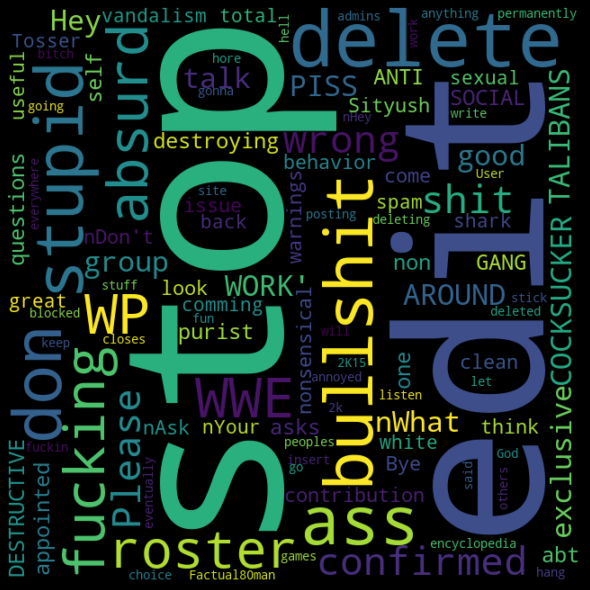

In [27]:
wordcloud=WordCloud(width=640,height=640,background_color='black',stopwords=STOPWORDS).generate(str(comments))
fig=plt.figure(figsize=(12,8),facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

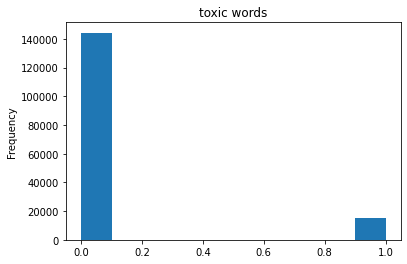

In [7]:
df_train['toxic'].plot(kind='hist',title='toxic words')

In [8]:
df_train['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [11]:
max_features=20000
max_len=400
x_tokenizer=text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenised=x_tokenizer.texts_to_sequences(x)
x_train=sequence.pad_sequences(x_tokenised,maxlen=max_len)

In [12]:
embedding_dim=100
embedding_index=dict()
f=open("Downloads/glove.6B/glove.6B.100d.txt")
for line in f:
    c=line.split()
    word=c[0]
    coefs=c[1:]
    coefs=np.asarray(coefs,dtype="float32")
    embedding_index[word]=coefs
f.close()
print(embedding_index['wonderful'])

[ 0.19742    0.5114     0.19043   -0.20615   -0.23031    0.25671
  0.22668    0.52012   -0.37792   -0.48753    0.10269   -0.40277
 -0.1782    -0.31256   -0.02286    0.336     -0.051616   0.29896
 -0.35625    1.0729    -0.20798    0.43333   -0.34719   -0.76778
  0.2825     0.51155   -0.22812    0.22737   -0.21706   -0.33989
 -0.52549    0.59313    0.19105   -0.55131    0.092535   0.008514
 -0.40322    0.46742    0.41892   -0.80948    0.28911    0.20081
  0.38232   -0.31885    0.27433    0.25773    0.17946   -0.072586
  0.08651   -0.70698   -0.1399    -0.34831    0.55074    0.28158
 -0.1381    -1.8367     0.43073    0.73006    0.39284   -0.44575
 -0.11662    1.4685    -0.66575   -0.39895    0.45373   -0.3806
  0.68791    0.033634   0.052634  -0.74561    0.36944    0.13868
  0.41492   -0.13675    0.6654     0.84479    0.094823  -0.41032
  0.26674    0.28715   -0.11217    0.18606    0.54309    0.2368
 -1.1154     0.14318    0.1404    -0.31462   -0.54193   -0.65945
  0.28       0.0023144  0

In [13]:
embedding_matrix=np.zeros((max_features,embedding_dim))
for word,index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        emb_vector=embedding_index.get(word)
        if emb_vector is not None:
            embedding_matrix[index]=embedding_index[word]

In [34]:
model=keras.Sequential()
model.add(Embedding(max_features,embedding_dim,Constant(embedding_matrix),trainable=False))

In [35]:
filters=250
kernel_size=3
hidden_dims=250
model.add(Conv1D(filters,kernel_size,padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,5,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dropout (Dropout)            (None, 250)              

In [36]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y,test_size=0.15,random_state=1)

In [38]:
batch_size=32
epochs=3
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val))

Train on 135635 samples, validate on 23936 samples
Epoch 1/3
135635/135635 [==============================] - 1117s 8ms/sample - loss: 0.1442 - acc: 0.9478 - val_loss: 0.1242 - val_acc: 0.9535
Epoch 2/3
135635/135635 [==============================] - 1064s 8ms/sample - loss: 0.1218 - acc: 0.9553 - val_loss: 0.1249 - val_acc: 0.9528
Epoch 3/3
135635/135635 [==============================] - 814s 6ms/sample - loss: 0.1071 - acc: 0.9601 - val_loss: 0.1238 - val_acc: 0.9575


In [39]:
test_df=pd.read_csv("Downloads/toxic-comments/test.csv")
test_x=test_df['comment_text'].values
x_tokenised=x_tokenizer.texts_to_sequences(test_x)
x_testing=sequence.pad_sequences(x_tokenised,maxlen=max_len)
y_test=model.predict(x_testing,verbose=1,batch_size=32)

153164/153164 [==============================] - 255s 2ms/sample


In [40]:
test_df['toxic']=['not toxic' if x<0.5 else 'toxic' for x in y_test]
test_df[['comment_text','toxic']].head(20)

,comment_text,toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,not toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
